In [1]:
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
# do that: conda install -c conda-forge umap-learn
import umap

In [15]:
# set default style of figures
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [16]:
#opening database and visualization
crops=pd.read_csv('./data/Production_Crops_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
crops.head(5)

grouped_yield_for_pca=(crops.query('`Element Code` == 5419')
        .query('`Year Code` == 2015')
        .query('`Item Code` >1000')
        .pivot(index='Area',columns='Item',values='Value')
        .fillna(value=0)
        .reset_index()
          )
grouped_yield_for_pca.head()

Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fruit Primary,"Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,Afghanistan,20829.0,21330.0,61111.0,16837.0,89744.0,7443.0,130903.0,15322.0,98165.0
1,Africa,15454.0,16357.0,112521.0,13939.0,89848.0,7310.0,86029.0,5348.0,82285.0
2,Albania,48738.0,48738.0,210307.0,57534.0,214057.0,13829.0,242574.0,43126.0,253610.0
3,Algeria,14001.0,14002.0,222348.0,12672.0,113518.0,10263.0,296099.0,18930.0,205598.0
4,American Samoa,0.0,0.0,0.0,0.0,41179.0,0.0,37647.0,0.0,38033.0


In [17]:
yield_data = grouped_yield_for_pca.drop('Area',axis=1).values

In [18]:
fertilizer_area=pd.read_csv('./data/Environment_Fertilizers_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
fertilizer_area.head(1)

fertilizer_area_2016=(fertilizer_area.query('`Item Code` == (3102)')
    .query('`Year Code` == 2015')
    .query('`Area Code` <300')
    .sort_values('Value', ascending=False)
)

In [82]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(yield_data)
embedding.shape

(245, 2)

In [83]:
def ferti_class(x): #associate a color to each bin of fertilizer
    if x<50 :
        return 0
    elif 50<=x<150:
        return 1
    else:
        return 2

In [84]:
def ferti_class2(x): #associate a color to each bin of fertilizer
    if x<50 :
        return 'low'
    elif 50<=x<150:
        return 'medium'
    else:
        return 'high'

In [85]:
reducer = umap.UMAP(random_state=1)
embedding = reducer.fit_transform(yield_data)
embedding2=pd.DataFrame(embedding)
embedding2=pd.merge(embedding2,grouped_yield_for_pca['Area'], left_index=True, right_index=True)
embedding2=pd.merge(embedding2,fertilizer_area_2016.loc[:,['Area','Value']],left_on='Area',right_on='Area')
embedding2['ferti_class']=embedding2.Value.apply(ferti_class)
embedding2['ferti_class2']=embedding2.Value.apply(ferti_class2)
embedding2.head()

,0,1,Area,Value,ferti_class,ferti_class2
0,-0.624415,3.843612,Afghanistan,11.71,0,low
1,-5.612064,0.741866,Albania,52.87,1,medium
2,-5.266939,0.455103,Algeria,11.83,0,low
3,-2.102001,3.392813,Angola,4.91,0,low
4,0.979927,4.831886,Antigua and Barbuda,1.70,0,low


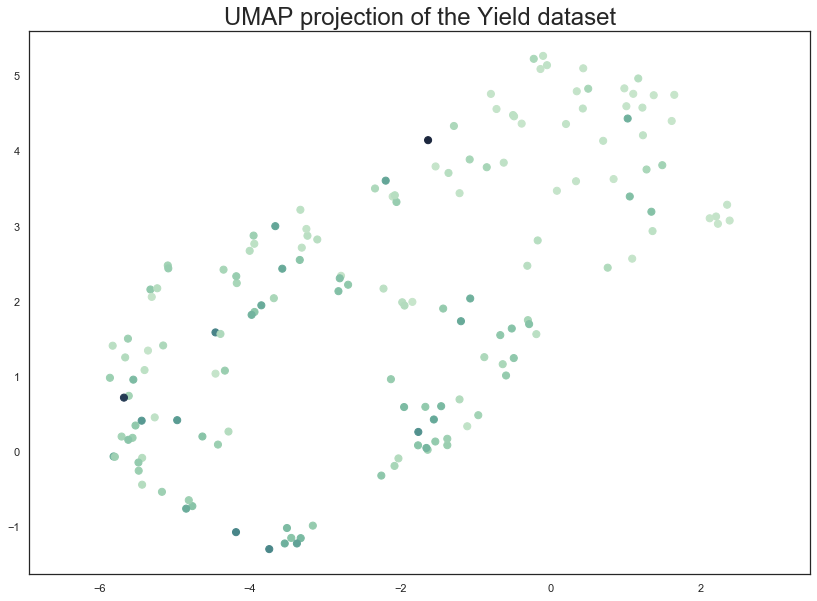

In [86]:
colors = ["green", "blue", "red"]
clarity_ranking = embedding2.Value
cmap = sns.cubehelix_palette(as_cmap=True,rot=-.4)
plt.scatter(embedding2[0], embedding2[1], c=clarity_ranking, s=50, cmap=cmap)
#plt.scatter(embedding2[0], embedding2[1], c=[sns.xkcd_palette(colors)[x] for x in embedding2.ferti_class.values])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Yield dataset', fontsize=24);

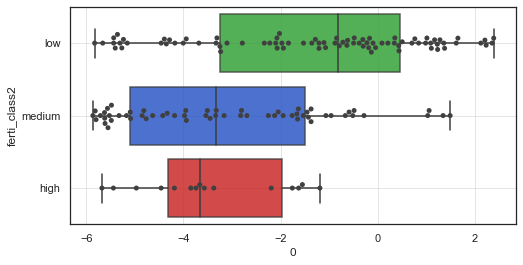

In [90]:
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
#cmap = sns.cubehelix_palette(rot=-.4)
ax = sns.boxplot(x=embedding2[0], y='ferti_class2', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[0], y='ferti_class2', data=embedding2, color=".25")
ax.grid(alpha=0.5)

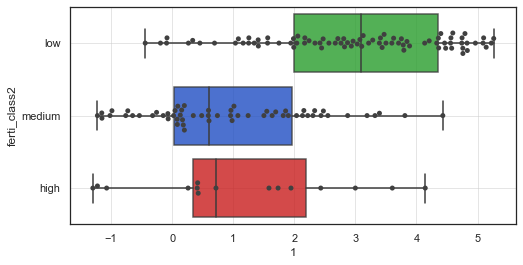

In [91]:
fig = plt.figure(figsize = (8,4))
#sns.palplot(sns.cubehelix_palette(3))
colors = ["green", "blue", "red"]
ax = sns.boxplot(x=embedding2[1], y='ferti_class2', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[1], y='ferti_class2', data=embedding2, color=".25")
ax.grid(alpha=0.5)

### A function doing all above for each year

In [52]:
# Creation of a function doing the umap 
def umap_year(year):
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .pivot(index='Area',columns='Item',values='Value')
            .fillna(value=0)
            .reset_index()
              )
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values # To perform the umap, we need to select only the features
    
    reducer = umap.UMAP(random_state=1)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)
    embedding2=pd.merge(embedding2,yield_for_merge['Area'], left_index=True, right_index=True)
    
    umap_fertilizer=(fertilizer_area
                    .query('Year == @year')
                    .query('`Area Code` <300')
                    .query('`Item Code` == (3102)')
                    .loc[:,['Area','Value']]
                    )
    embedding2=pd.merge(embedding2,umap_fertilizer,left_on='Area',right_on='Area')
    embedding2[1]=embedding2[0]/max(embedding2[0])
    embedding2['Value']=embedding2['Value']/max(embedding2['Value'])
    
    coef = np.polyfit(embedding2[0],embedding2.Value,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

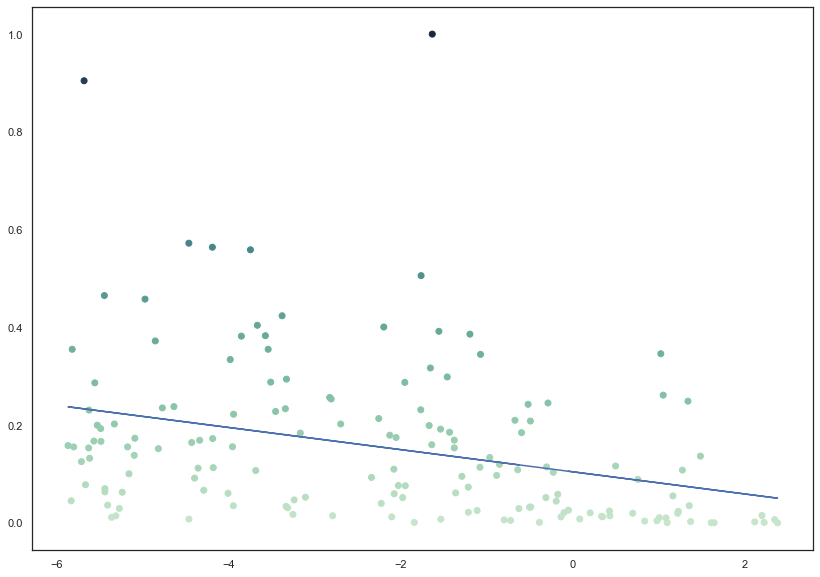

[-0.02268408  0.10455215]


In [115]:
#Visualization for year 2015
vis_2015=umap_year(2015)
embedding2=vis_2015[1]
coef = vis_2015[2]
poly1d_fn = np.poly1d(coef)
clarity_ranking = embedding2.Value
cmap = sns.cubehelix_palette(as_cmap=True,rot=-.4)
plt.scatter(embedding2[0], embedding2.Value,c=clarity_ranking, cmap=cmap)
plt.plot(embedding2[0], poly1d_fn(embedding2[0]))
plt.show()
print(coef)

In [55]:
# umap for all years available in the fertilizer dataset (the more restrictive dataset)
mean=[]
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    print(year)
    adding=umap_year(year)
    mean.append([adding[0],adding[2][0]])
mean=pd.DataFrame(mean)

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


Text(0.5, 1.0, 'Evolution of linear regression (fertilizer/axe0) over the year')

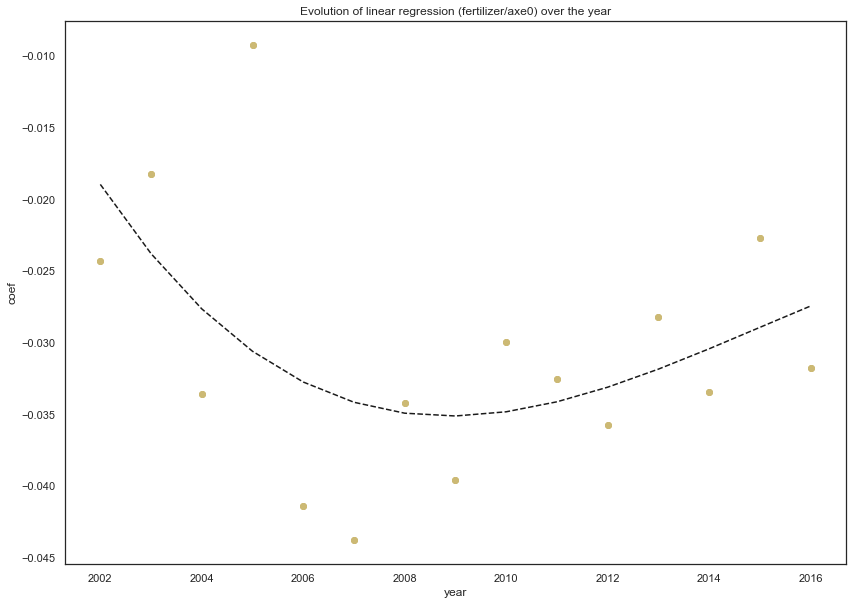

In [58]:
# look at coef over the years
coef = np.polyfit(mean[0],mean[1],3) #test regression dim 3 ...
poly1d_fn = np.poly1d(coef)
plt.plot(mean[0],mean[1], 'yo',mean[0], poly1d_fn(mean[0]), '--k')
plt.plot(mean[0],mean[1], 'yo')
plt.xlabel('year')
plt.ylabel('coef')
plt.title('Evolution of linear regression (fertilizer/axe0) over the year')